In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as m
import itertools
import seaborn as sns
import random 

## Input

In [2]:
df = pd.read_csv("dataset/titanic.csv")
target = "Survived" 
target_objective = "binary","maximise","minimise","multiple, maximise / minimise", "number_of_rows" "etc" 
categorical_columns = ['Pclass','Sex','SibSp','Embarked']
numerical_col = ['Age','Fare']
numerical_values_bining_quantile_nbr = 5

## Isolate Categorical and Numerical Features

In [3]:
categorical = list(df.select_dtypes(include = ['object']).columns)

In [4]:
categorical

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

## Basic KPIs

In [5]:
df_shape = df.shape
df_shape

(891, 12)

In [6]:
list_columns = df.columns.to_list()
list_columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Survived
0,549
1,342


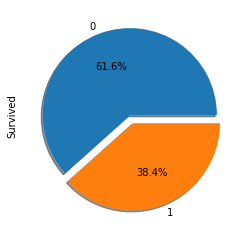

In [8]:
# Case of categorical classification
display(pd.DataFrame(df[target].value_counts()))
df[target].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=True)
plt.show()

In [9]:
pd.DataFrame(df[target].describe())

,Survived
count,891.000000
mean,0.383838
std,0.486592
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Type of data:

- numerical continuous (floats)
- numerical discreet (integer)
- categorical (contain letters) 
    - Of importance if the number of unique values of the categorical is not to small compared 
    to the numbuer of unique ID (case where almost all ID have the same category) and not to high (case where each ID has a unique category). Need to rank by 
- categorical ordinal - ordered category (is categorical - and .

## Missing Values

In [10]:
def missing_values(df, df_shape, list_columns):
    '''input : 
    - dataframe: full pandas dataframe
    - tuple: main dataframe shape
    - list: dataframe columns 
    - floats: threshold ratio of missing value acceptable for ID column
    - floats: threshold ratio of missing value acceptable for all other column
    
    output: 
    - string - Name of the column to use for counts 
    - Boolean - True if too many missing value, 20% threshold met, False otherwise.
    - dictionnary - missing value dict {column name : number of missing values}'''
    
    # Threshold of missing values that the main col used for groupby count must meet to raise an alert
    threshold_main_col = 0.01
    # Threshold of missing values that the other colmust meet to raise an alert
    threshold_other_col = 0.1
    
    missing_val_serie = df.isnull().sum().sort_values()
    col = missing_val_serie.index[0]
    number_of_missing_value_main_col = missing_val_serie[0]
    ratio = number_of_missing_value_main_col / df_shape[0]
    threhold_met = False
    if ratio >= threshold_main_col:
        threhold_met = True 
    
    col_with_missing_value = [col for col in list_columns if df[col].isnull().sum()/df_shape[0] > threshold_other_col] 
    
    return col,threhold_met,missing_val_serie.to_dict(),col_with_missing_value

In [11]:
id_col,threshold_met,serie,col_with_missing_value = missing_values(df,df_shape,list_columns)

In [12]:
serie

{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Embarked': 2,
 'Age': 177,
 'Cabin': 687}

In [13]:
# FOR NOW
df.dropna(subset = ['Age','Embarked'],axis = 0, inplace = True)

****

## Entropy Calculation

 For categorical variables

In [14]:
df_groupby = pd.DataFrame(df.groupby(by = ['Sex',target])[id_col].count()).rename({id_col:"count"},axis =1)
df_groupby.reset_index(level = -1,inplace = True)
df_groupby

,Survived,count
Sex,,
female,0,64
female,1,195
male,0,360
male,1,93


In [15]:
def entropy(df_groupby, target_col, base=2):
    """input: 
    - dataframe : groupby dataframe 
    - target_col : string corresponding to the column that we want to classify/study
    - list : splitting criteria, usually the name of the columns used to proceed the groupby
    - integer : base of the logarithm used for entropy calculation
    output:
    - entropy value of the splitting criteria belonging to [0-1] Goal is to reach a low entropy, with a low diversity.
    
    entropy calculation inspired from here https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8
        """ 
    total_entropy = 0
    count_total = df_groupby['count'].sum()
    
    # Case where the splitting criteria is categorical 
    list_splited_groups = list(df_groupby.index.unique())
    #list_splited_groups = list(df_groupby[splitting_criteria].unique()) # Used to be this, splitting criteria was inputed
    
    # Iterating over the various groups
    for splitting_index in list_splited_groups:
        df_splitted = df_groupby.loc[[splitting_index]]
        #df_splitted = df_groupby[df_groupby[splitting_criteria] == splitting_index] # Used to be this 
        total = df_splitted['count'].sum()
        
        # Case where the target variable is categorical
        # Iterating over the different target classes within the group
        entropy_group = 0
        for target_value in df_splitted[target_col].unique():
            count = df_splitted[df_splitted[target_col] == target_value]['count'].iloc[0]
            
            if count == 0:
                entropy_group -= 0
            else :
                entropy_group -= (count/total)*m.log(count/total,base)
                
        total_entropy += entropy_group*(total/count_total)
    
    return total_entropy

In [16]:
total_entropy = entropy(df_groupby, target_col = target, base=2)
total_entropy

0.7594106895489579

## Numerical Features

- Bining 
- Correlation calculatio

In [17]:
def bining(df, nbr_quantile, numerical_col):
    list_new_categorical_features = []
    for col in numerical_col:
        df[f'{col}_{nbr_quantile}_quantile'] = pd.qcut(df[col],q=nbr_quantile)
        list_new_categorical_features.append(f'{col}_{nbr_quantile}_quantile')
    return list_new_categorical_features

list_new_cat_features = bining(df,numerical_values_bining_quantile_nbr,numerical_col)

In [18]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_5_quantile,Fare_5_quantile
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(19.0, 25.0]","(-0.001, 7.902]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(31.0, 41.0]","(46.9, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(25.0, 31.0]","(7.902, 12.925]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(31.0, 41.0]","(46.9, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(31.0, 41.0]","(7.902, 12.925]"


## Feature engineering Generator

- Text
- Email
- Title
- Date
- ...

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from stop_words import get_stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amaurylejay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def get_tfidf_vectorizer(df, field, vectorizer):
    tfidf = vectorizer.fit_transform(df[field])
    tfidf_cols = vectorizer.get_feature_names()
    print(tfidf_cols)
    temp = pd.DataFrame(data=tfidf.todense(), columns=['tfidf_' + field + '_' + i for i in tfidf_cols])
    df = pd.concat([df, temp], axis=1)
    return df

#custom tokenizer for tfifd
def custom_tokenizer(s):
    return s.split(',')

In [21]:
df = get_tfidf_vectorizer(df,'Name', TfidfVectorizer(analyzer='word',ngram_range=(1,3),stop_words = stopwords.words('english'),lowercase=True,max_features=50,binary=True,norm=None,use_idf=False, tokenizer=custom_tokenizer))

[' miss. anna sofia', ' miss. bertha', ' miss. kate', ' miss. mary', ' mr. charles henry', ' mr. george', ' mr. ivan', ' mr. james', ' mr. samuel', ' mr. william', ' mr. william henry', ' mr. william john', 'allison', 'andersson', 'asplund', 'baclini', 'beane', 'brown', 'carter', 'collyer', 'davies', 'ford', 'fortune', 'goldsmith', 'goodwin', 'graham', 'gustafsson', 'hansen', 'harper', 'harris', 'hart', 'hickman', 'jensen', 'johansson', 'johnson', 'jussila', 'laroche', 'mellinger', 'navratil', 'newell', 'palsson', 'panula', 'rice', 'richards', 'skoog', 'taussig', 'thayer', 'van impe', 'vander planke', 'west']


In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
doc = nlp(df['Name'].iloc[0])
df['Name'].iloc[0]

In [ ]:
for token in doc:
    print(token.is_stop) # GREAT
    print(token.lemma_)

In [ ]:
spacy.explain("npadvmod")

In [ ]:
colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"ents": ["ORG"], "colors": colors}
displacy.render(doc, style="ent")

In [ ]:
for ent in doc.ents:
    print(ent.label_) # GREAT

- other label "org", "Group", "money"

## Feature redundancy 

- Goal is just to flag them and remove them from the entropy calculation if too much correlated 

In [ ]:
# Calculating correlation of features
df_corr = df.drop([id_col], axis=1).corr()
# Creating a mask to get rid of half of the correlation matrix 
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# Set size of the figure
sns.set(rc={'figure.figsize':(7,5)})
# Generate a visualization of the correlation matrix
sns.heatmap(df_corr, annot=True, mask = mask,square=True, linewidths=.5)
plt.title("Feature Correlation")
plt.show()

In [ ]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    threshold = 0
    color = 'red' if val < threshold else 'black'
    return 'color: %s' % color

#display(corr.style.bar(align='mid', color=['#d65f5f', '#5fba7d']))

display(df.corr().style.applymap(color_negative_red))
df.corr().abs().rank(ascending=False)

## Feature combination

- need to find a way to find the type of columns (i.e. categorical, numerical etc)
- need to find a way to calculate correlation with numerical colums with respect to the target value, whether it's categorical like in our case or sales / visits (in the future).

In [ ]:
categorical_columns = categorical_columns + list_new_cat_features
categorical_columns

In [ ]:
df.head()

In [ ]:
def categorical_feature_combinations(main_df, id_col, categorical_col):

    dic_features_entropy = {}
    
    # Iterating over all base categorical features
    for feature in categorical_col:
        df_groupby = pd.DataFrame(main_df.groupby(by = [feature,target])[id_col].count())
        df_groupby.rename({id_col:"count"},axis =1,inplace = True)
        df_groupby.reset_index(level = -1,inplace = True)
        dic_features_entropy[feature] = entropy(df_groupby, target_col = target, base=2)
    
    # Iterating over all combination of categorical features
    for combination_of_feature in itertools.combinations(categorical_columns, 2):
        df_groupby = pd.DataFrame(main_df.groupby(by = [i for i in combination_of_feature + (target,)])[id_col].count()).rename({id_col:"count"},axis =1)
        df_groupby.rename({id_col:"count"},axis =1,inplace = True)
        df_groupby.reset_index(level = -1,inplace = True)
        dic_features_entropy["_:_".join([i for i in combination_of_feature])] = entropy(df_groupby, target_col = target, base=2)
        
    return dic_features_entropy

In [ ]:
dic_features_entropy = categorical_feature_combinations(df,id_col,categorical_columns)
dic_features_entropy

In [ ]:
df_features_entropy = pd.DataFrame(data = dic_features_entropy.values(),index = dic_features_entropy.keys(),columns = ['entropy']).sort_values(by = 'entropy')
df_features_entropy

- Concretely showing the features that distinguish the most groups with respect to the target variable 
- Need to account for proportions

## Visualisation 

- Need to include the proportion as well - otherwise example of combination of class and sibling ?? Third class many sibblings all die, not because of proba but simply because we don't have any obervable data that says otherwise !

In [ ]:
def visualise(feature_entropy_ranking):
    # Create dataframe to plot
    df_visu = pd.DataFrame(df.groupby(by = list(df_features_entropy.index[feature_entropy_ranking].split("_:_"))+ [target])[id_col].count())
    # reset indexes
    df_visu = df_visu.sort_values(by = id_col).reset_index()
    # create a column
    df_visu['visu_axis'] = df_visu.drop([id_col,target], axis=1).astype(str).apply('_'.join, axis=1)
    
    for target_value in df_visu[target].unique():
        # color
        r,g,b = random.random(),random.random(),random.random()
        # df to plot
        df_to_plot = df_visu[df_visu[target]==target_value]
        objects = tuple(df_to_plot['visu_axis'])
        y_pos = np.arange(len(objects))
        performance = list(df_to_plot[id_col])
        # plotting
        plt.bar(y_pos, performance, align='center', color = (r,g,b), alpha=0.5)
        plt.xticks(y_pos, objects, rotation='vertical')
        plt.ylabel('Count')
        plt.legend(str(target_value))
        plt.title(" ".join([str(target_value), df_features_entropy.index[feature_entropy_ranking]]))
        print(i," ".join([str(target_value), df_features_entropy.index[feature_entropy_ranking]]))
        plt.legend(str(target_value))
        plt.show()
    
    print('------------------------------------------------------------------------------------------------')
    return df_visu

In [ ]:
for i in range(0,5):
    visualise(i)

### Main call

- Need to call the missing value
- Then the bining of numerical columns
- Then the Entropy
- Then the feature combination
- Then visualisation

In [ ]:
# TODO: Replace missing values strat? 

# To Do: Numerical target value 
    # TODO: Handle entropy calculation when the target is not categorical DONE
    # To Do: Numerical Value correlation / growth 

# To Do: Server visualisation (Dask)
# To Do: Large Data Frame handling / Paralization
# To Do: Library deployment

# TODO: Target is not a column that we try to maximise, minimise or find correlation to, but rather a number of rows
    # To Do: Visit Maximisation target value

# TODO: Feature Engineering Generator
    # Decide how many features we choose for text
    # To Do: Feature extractor (text) DONE

In [ ]:
print("this is new")